Neural Network
=======

### 01 - Libraries and Parameters

Libraries

In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, roc_auc_score

Parameters:

In [2]:
learning_rate = 1e-4
epochs = 500
batch_size = 250

### 02 - Data

Load Data:

In [3]:
data = pd.read_csv("../data/loans_sample_processed.csv", sep = "^").sample(100000, random_state = 4290)

In [4]:
data.head()

,funded_amnt_inv,installment,int_rate,annual_inc,dti,total_rec_late_fee,total_acc,manager,refinance,term_ 36 months,...,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,application_type_Individual,application_type_Joint App,non_payment
337231,15000.0,555.32,19.72,55000.00,15.77,0.0,47.0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
556157,15400.0,515.12,12.49,110000.00,10.19,0.0,26.0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
580514,15000.0,501.74,12.49,44275.82,13.93,0.0,17.0,0,1,1,...,0,0,0,0,0,0,1,1,0,1
446532,12000.0,377.09,8.19,69000.00,19.63,0.0,19.0,0,1,1,...,0,0,0,0,0,0,1,1,0,0
95642,2300.0,78.60,13.99,30000.00,18.68,0.0,11.0,1,1,1,...,0,0,0,0,0,0,1,1,0,0


In [5]:
data.shape

(100000, 38)

### 03 - Data Preparation

Normalization:

In [6]:
numeric_variables = ['funded_amnt_inv', 'installment', 'int_rate', 'annual_inc', 'dti',
                     'total_rec_late_fee', 'total_acc']

In [7]:
scaler = RobustScaler()

In [8]:
scaler.fit(data[numeric_variables])

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)

In [9]:
data[numeric_variables] = scaler.transform(data[numeric_variables])

In [10]:
data.head()

,funded_amnt_inv,installment,int_rate,annual_inc,dti,total_rec_late_fee,total_acc,manager,refinance,term_ 36 months,...,emp_length_< 1 year,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,application_type_Individual,application_type_Joint App,non_payment
337231,0.248963,0.552989,1.068254,-0.222222,-0.134822,0.0,1.533333,0,1,1,...,0,0,0,0,0,0,1,1,0,0
556157,0.282158,0.428492,-0.079365,1.000000,-0.596361,0.0,0.133333,0,1,1,...,0,0,0,0,0,0,1,1,0,0
580514,0.248963,0.387055,-0.079365,-0.460537,-0.287014,0.0,-0.466667,0,1,1,...,0,0,0,0,0,0,1,1,0,1
446532,0.000000,0.001022,-0.761905,0.088889,0.184450,0.0,-0.333333,0,1,1,...,0,0,0,0,0,0,1,1,0,0
95642,-0.804979,-0.923382,0.158730,-0.777778,0.105873,0.0,-0.866667,1,1,1,...,0,0,0,0,0,0,1,1,0,0


Train / Test split:

In [11]:
X = data.loc[:, data.columns!='non_payment']

In [12]:
y = data['non_payment']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4290)

Data Transformation:

In [14]:
X_train_split = X_train.values

num_batches = int(X_train_split.shape[0] / batch_size)
X_train_split = np.array_split(X_train_split, num_batches)

In [15]:
X_test = X_test.values

In [16]:
y_train_split = y_train.values.astype(np.int32)

y_train_split = np.array_split(y_train, num_batches)

In [17]:
y_test = y_test.values.astype(np.int32)

### 03 - Neural Network:

#### 03.1 - Architecture

In [18]:
_, number_of_variables_in_train = np.shape(X_train_split[0])
num_hidden_0 = number_of_variables_in_train
num_hidden_1 = 100
num_hidden_2 = 50
num_hidden_3 = 1

#with tf.device('/cpu:0'):
x = tf.placeholder(dtype = tf.float64, shape = [None, num_hidden_0])
y = tf.placeholder(dtype = tf.float64, shape = [None,1])

weights = {
    'w1': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_0, num_hidden_1], dtype=tf.float64)),
    'w2': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_1, num_hidden_2], dtype=tf.float64)),
    'w3': tf.Variable(tf.truncated_normal(stddev=.1, shape=[num_hidden_2, num_hidden_3], dtype=tf.float64)),
}

biases = {
    'b1': tf.Variable(tf.random_normal([num_hidden_1], dtype=tf.float64)),
    'b2': tf.Variable(tf.random_normal([num_hidden_2], dtype=tf.float64)),
    'b3': tf.Variable(tf.random_normal([num_hidden_3], dtype=tf.float64)),
}

#with tf.device('/gpu:0'):
hidden_1 = tf.nn.relu(tf.add(tf.matmul(x, weights['w1']), biases['b1']))
hidden_2 = tf.nn.relu(tf.add(tf.matmul(hidden_1, weights['w2']), biases['b2']))
logits = tf.add(tf.matmul(hidden_2, weights['w3']), biases['b3'])

predictions = tf.nn.sigmoid(logits)

#### 03.2 - Loss Function

In [19]:
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels = y, logits = logits))

#### 03.3 - Optimizer

In [20]:
optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

#### 03.4 - TensorFlow Session

In [21]:
start_time = time.time()
init = tf.global_variables_initializer()
losses = []

with tf.Session() as session:
    
    session.run(init)
    
    for epoch in range(epochs):
        avg_cost = 0
    
        for x_batch, y_batch in zip(X_train_split, y_train_split):
            y_batch_shape = np.shape(y_batch)[0]
            y_batch = y_batch.reshape(y_batch_shape, 1)

            _, eval_loss = session.run([optimize, loss],
                                       feed_dict={x: x_batch, y:y_batch})
            
        avg_cost += eval_loss
    
        avg_cost /= num_batches
            
        losses.append(avg_cost)
        
        if epoch % 100 == 0: 
            print("epoch: {}".format(epoch))
            print("loss: {}".format(avg_cost))
    
    # Predictions in the train set
    X_train = X_train.values
    y_scores_train = session.run([predictions], feed_dict = {x: X_train})
    
    # predictions in the test set
    y_scores_test = session.run([predictions], feed_dict = {x: X_test})

final_time = time.time()

epoch: 0
loss: 0.0015785265471913311
epoch: 100
loss: 0.0014797527215884968
epoch: 200
loss: 0.0014743479036021738
epoch: 300
loss: 0.0014673381695210264
epoch: 400
loss: 0.001456407839587156


In [22]:
print("Training Time: {} minutes".format((final_time - start_time)/60))

Training Time: 4.654420292377472 minutes


### 04 - Evaluate the model

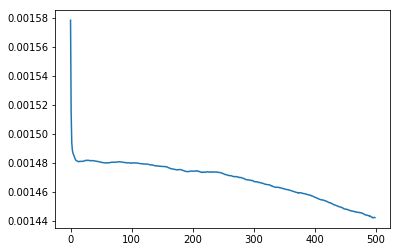

In [23]:
plt.plot(losses)
plt.show()

Train Set:

In [24]:
y_scores_train = pd.DataFrame(y_scores_train[0])

# AUC
auc = roc_auc_score(y_train.values, y_scores_train)
print("AUC in the train set: {}". format(auc))

# Gini
gini = auc * 2 - 1
print("Gini in the train set: {}".format(gini))

AUC in the train set: 0.7498926899308276
Gini in the train set: 0.49978537986165517


Test set:

In [25]:
y_scores_test = pd.DataFrame(y_scores_test[0])

# AUC
auc = roc_auc_score(y_test, y_scores_test)
print("AUC in the test set: {}". format(auc))

# Gini
gini = auc * 2 - 1
print("Gini in the test set: {}".format(gini))

AUC in the test set: 0.7061796300017569
Gini in the test set: 0.41235926000351375


__Output__:

In [29]:
y_scores_train.to_csv("../output/y_scores_train_nn.csv", sep = "^", index = False)
y_scores_test.to_csv("../output/y_scores_test_nn.csv", sep = "^", index = False)